In [ ]:
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional,Flatten, SpatialDropout1D,SpatialDropout2D,SpatialDropout3D
from python_speech_features import mfcc
from python_speech_features import logfbank
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder,normalize
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import scipy.io.wavfile as wav
import numpy as np
import keras
import csv
import os

In [ ]:
#Calculating x_test and y_test
scaler = MinMaxScaler(feature_range=(0,1))
test_labels = []
test_data = []

#test_labels.txt is a txt file with all labels for the speech samples that is required for the evaluation. We loop through it to calculate the MFCC value for each speech sample and then normalize it 
with open('test_labels.txt', newline='') as tsvfile:
    reader = csv.DictReader(tsvfile)
    reader = csv.reader(tsvfile, delimiter=' ')
    for row in reader:
        wav_file = "test/" + row[0]
        (rate,sig) = wav.read(wav_file)

        #Getting the MFCC value from the .wav files.
        mfcc_feat = mfcc(sig,rate)
        scaler = scaler.fit(mfcc_feat)

        #Normalizing the MFCC values.
        normalized = scaler.transform(mfcc_feat)
        test_data.append(normalized)
        test_labels.append(str(row[1]))
    label_encoder_test = LabelEncoder()
    vec_test = label_encoder_test.fit_transform(test_labels)

    #One hot encoding the labels
    one_hot_labels_test = keras.utils.to_categorical(vec_test, num_classes=6)
    Y_test = one_hot_labels_test
    X_test = np.array(test_data,dtype=np.float32)

In [ ]:
#Loading x_train
train_labels = []

#train_labels.txt is a txt file with all labels for the speech samples that is required for the evaluation. We loop through it to calculate the MFCC value for each speech sample and then normalize it 
with open('mfcc_partition_100_299/train_labels.txt', newline='') as tsvfile:
    reader = csv.DictReader(tsvfile)
    reader = csv.reader(tsvfile, delimiter='\t')
    X_train = []
    for row in reader:
        mfcc_array = np.loadtxt(("mfcc_partition_100_299/" + row[0]))
        scaler = scaler.fit(mfcc_array)
        normalized = scaler.transform(mfcc_array)
        X_train.append(np.array(normalized, dtype=np.float32))
        train_labels.append(str(row[1]))

In [ ]:
X_train_array = np.array(X_train)

In [ ]:
#calculate y_train
label_encoder = LabelEncoder()
vec = label_encoder.fit_transform(train_labels)
one_hot_labels_train = keras.utils.to_categorical(vec, num_classes=6)
Y_train = one_hot_labels_train
X_train_array.shape,Y_train.shape, X_test.shape,Y_test.shape

((95811, 299, 13), (95811, 6), (3130, 299, 13), (3130, 6))

In [ ]:
#Create a LSTM model
callbacks = [
             EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5,mode = 'min')
            ]

#attempt with 200 units
model_11 = Sequential()
model_11.add(LSTM(200,input_shape=(299,13),return_sequences=False))
model_11.add(Dense(6,activation='softmax'))
model_11.summary()

model_11.compile(optimizer=Adam(amsgrad=True, lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 100
BATCH_SIZE = 40
SAMPLES_PER_EPOCH = len(range(0, len(X_train_array), BATCH_SIZE))

#Training the model
history = model_11.fit(X_train_array, 
                    Y_train, 
                    epochs=EPOCHS,
                    callbacks = callbacks,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, Y_test),
                    verbose=1,
                    shuffle=True
                   )

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 200)               171200    
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 1206      
Total params: 172,406
Trainable params: 172,406
Non-trainable params: 0
_________________________________________________________________
Train on 95811 samples, validate on 3130 samples
Epoch 1/100
95811/95811 [==============================] - 1809s 19ms/step - loss: 1.7655 - accuracy: 0.2300 - val_loss: 1.7851 - val_accuracy: 0.1850
Epoch 2/100
95811/95811 [==============================] - 1685s 18ms/step - loss: 1.7272 - accuracy: 0.2637 - val_loss: 1.7771 - val_accuracy: 0.2125
Epoch 3/100
95811/95811 [==============================] - 1675s 17ms/step - loss: 1.6712 - accuracy: 0.3029 - val_loss: 1.7372 - val_accuracy: 0.2629
Epoch 4

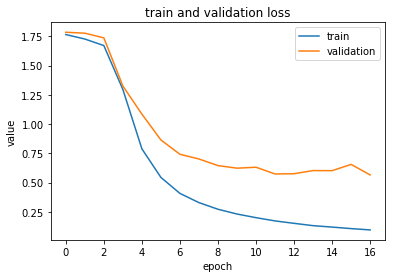

In [ ]:
#plotting the loss
history = model_11.history
#print(history.history['loss'])
#print(history.history['val_loss'])
pyplot.plot(history.history['loss'])
pyplot.plot(history.history["val_loss"])
pyplot.title("train and validation loss")
pyplot.ylabel("value")
pyplot.xlabel("epoch")
pyplot.legend(['train','validation'])

In [ ]:
scores = model_11.evaluate(X_test, Y_test, verbose=1)
scores

3130/3130 [==============================] - 23s 7ms/step


[0.5657648107019095, 0.8341853022575378]

In [ ]:
#The accuracy is seen to be 83%

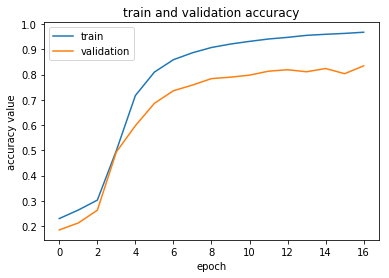

In [ ]:
#plotting the loss
history = model_11.history
#print(history.history['loss'])
#print(history.history['val_loss'])
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history["val_accuracy"])
pyplot.title("train and validation accuracy")
pyplot.ylabel("accuracy value")
pyplot.xlabel("epoch")
pyplot.legend(['train','validation'])

In [ ]:
#Saving the model for future use
model_11.save("90K_3sec_200Units_LSTM_50Epoch_83Acc.model")